# Getting the data

Data file row

    0024  J020329.86-091020.3 666-52149-109   2000        3      Certain

## SDSS

Get a single spectrum from SDSS

    $ wget https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/0666/spec-0666-52149-0109.fits
    
How to read the files

    http://classic.sdss.org/dr7/products/spectra/read_spSpec.html
    
What's in the files
    
    http://classic.sdss.org/dr7/products/spectra/
    
## Galex

To get a list of all files, use MAST SQL Search 

    http://galex.stsci.edu/GR6/?page=sqlform

with the following query

    SELECT fuv_filename, nuv_filename FROM SPECEXTRACT
    
Output is written to `data/galex_all.csv`, to extract tile names only, run

    $ cat galex_all.csv | cut -d',' -f 1 | grep -oP '[^/]+-[a-z]+-[a-z]+.fits' | grep -oP '^[^-]+' > galex_all.txt
    
Figure out the actual URL of the FITS file. Let's assume tile name is `GI3_104005_J020329m091020`

    $ cat galex_all.csv | grep GI3_104005_J020329m091020 | cut -d',' -f 1 | grep -oP '01-vsn[\w/-]+\.fits'
    
Replace `-gsax` with `-gsp` and the `-fg-` part with `-ng-` to get nuv part of spectrum.

Find spectra in Galex, specify Ra, Dec in sexagesimal format, e.g. 02:03:29.86, -09:10:20.3

    http://galex.stsci.edu/GR6/?page=tilelist&survey=spectra&showall=Y
    
Data format

    http://www.galex.caltech.edu/DATA/gr1_docs/GR1_Pipeline_and_advanced_data_description_v2.htm

Grab the fits file

    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-ng-gsp.fits.gz
    
    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-fg-gsp.fits.gz
    


In [1]:
%pylab inline

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pwd

/mnt/local/data/astro/lls/py


## Coordinate conversion

In [3]:
c = SkyCoord.from_name('J020329.86-091020.3')
c

<SkyCoord (ICRS): (ra, dec) in deg
    ( 30.87443, -9.17231)>

# Load and plot an SDSS spectrum

Note, that these are sky-subtracted but not corrected for foreground extinction.

In [4]:
sdss = fits.open('../data/sdss/fits/spec-0666-52149-0109.fits')
spec = sdss[1]
info = sdss[2]

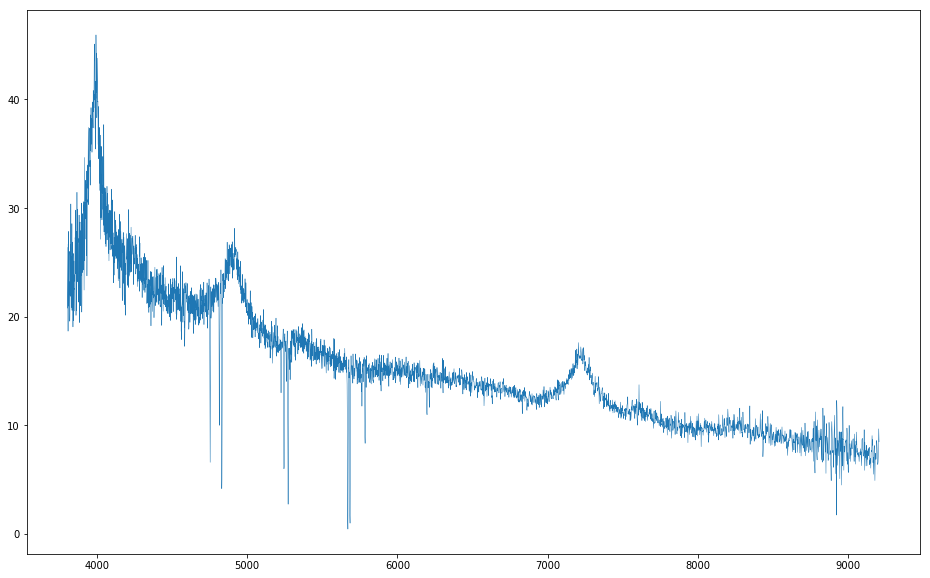

In [5]:
z = info.data['Z']
wl_sdss = 10**spec.data['loglam']
fl_sdss = spec.data['flux']

figsize(16, 10)
plot(wl_sdss, fl_sdss, lw=0.5)

# Load and plot a Galex spectrum

In [6]:
fuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-fg-gsp.fits.gz')
nuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-ng-gsp.fits.gz')

## Find closest object

In [7]:
print(c)
ra_all = nuv[1].data['alpha_j2000']
dec_all = nuv[1].data['delta_j2000']
idx = np.where(np.abs(ra_all - c.ra.value) < 1./3600.)
print(idx)
idx = idx[0][0]
ra = ra_all[idx]
dec = dec_all[idx]
print(ra, dec)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 30.87443, -9.17231)>
(array([186]),)
30.8742132449 -9.17233051178


# Figure out wavelength grid

In [8]:
print(fuv[1].data['zero'][idx])
print(fuv[1].data['disp'][idx])

1300.0
3.5


-999.0


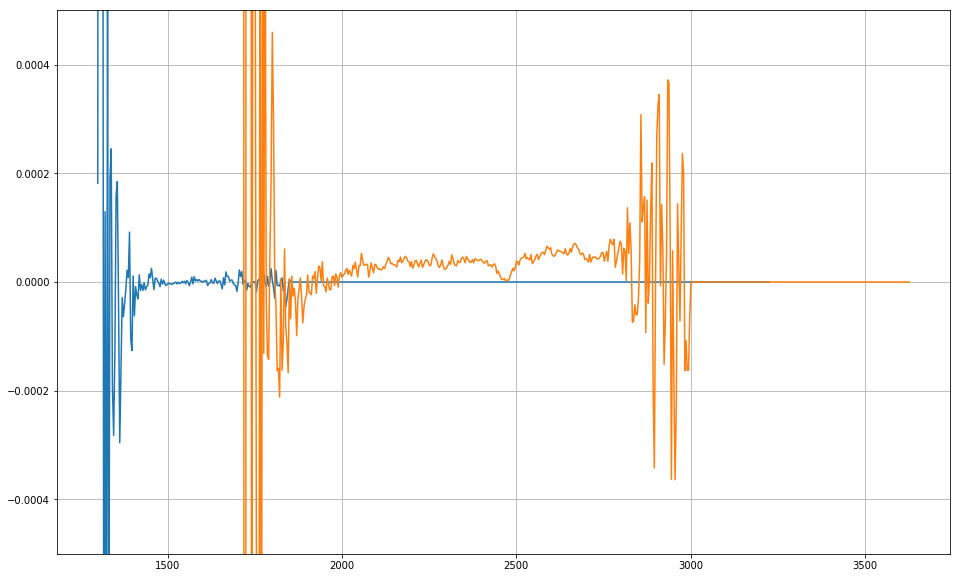

In [9]:
z = nuv[1].data['redshift'][idx]
fl_fuv = fuv[1].data['obj'][idx]
wl_fuv = fuv[1].data['zero'][idx] + fuv[1].data['disp'][idx] * np.linspace(0, fl_fuv.shape[0] - 1, fl_fuv.shape[0])

fl_nuv = nuv[1].data['obj'][idx]
wl_nuv = nuv[1].data['zero'][idx] + nuv[1].data['disp'][idx] * np.linspace(0, fl_nuv.shape[0] - 1, fl_nuv.shape[0])

print(z)

figsize(16, 10)
grid(True)
ylim(-0.0005, 0.0005)
plot(wl_fuv, fl_fuv)
plot(wl_nuv, fl_nuv)

## Figure out flux unit conversion

Nice conversion chart:

    https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf


* SDSS is in $10^{-17}$ erg/sec/cm$^{2}$/A
* Galex is in photon/sec/cm$^{2}$/A

In [10]:
fl_nuv_c = 1.99e-8 * 1e17 * fl_nuv / wl_nuv
fl_fuv_c = 1.99e-8 * 1e17 * fl_fuv / wl_fuv

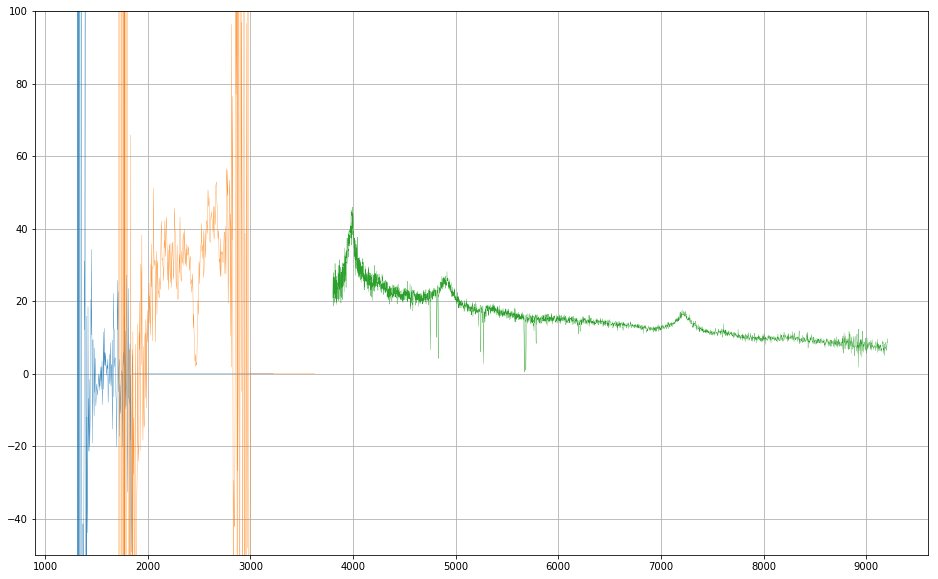

In [15]:
figsize(16, 10)
grid(True)
ylim(-50, 100)
plot(wl_fuv, fl_fuv_c, lw=0.3)
plot(wl_nuv, fl_nuv_c, lw=0.3)
plot(wl_sdss, fl_sdss, lw=0.3)